# Load Libraries & Data

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np

from SepMe.utils.graph_neighbourhoods import *
from SepMe.utils.graph_purity import *

SepMe - INFO - MLFLOW_TRACKING_URI - http://localhost:5000


In [4]:
data_path = '/Users/morarica/Developer/SepMe/data/binary_data/RESULTS_EUROVIS2015.csv'
folder_path = "/Users/morarica/Developer/SepMe/data/binary_data/EUROVIS_new/"
os.getcwd()

'/Users/morarica/Developer/SepMe/Jupyters/scripts_sanitychecks'

In [5]:
df = pd.read_csv(data_path)
#print(df.head())

for i, file in enumerate(df.fileName):
    file_name = folder_path + file.split('.csv')[0] + '_cls' + str(df.classNum[i]) + '.csv'
    try:
        sample_df = pd.read_csv(file_name, names=['x','y','class'])
        break
        #print(sample_df.head(1))
    except FileNotFoundError:
        print('File \'' + file +'\' does not exist.')

sample_df.head()
df = sample_df
df = df.astype({'x': 'float64', 'y':'float64'})

folder = '../../data/orig_data/input_data/enhanced_dim_data/'
df = pd.read_csv(folder + 'tse300_d6-d12.csv')

193
{0, 1, 2, 3, 4, 5, 6, 7}


,x,y,class,orig_class
0,0.000000,0.069444,4,4
1,0.019231,0.250000,4,4
2,0.038462,0.194444,4,4
3,0.038462,0.263889,0,0
4,0.057692,0.013889,4,4
5,0.057692,0.138889,4,4
6,0.057692,0.152778,4,4
7,0.057692,0.277778,4,4
8,0.076923,0.041667,4,4
9,0.096154,0.000000,4,4


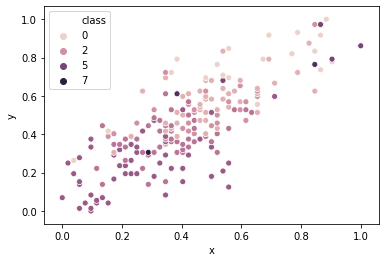

In [6]:
#df = sample_df
#df = pd.read_csv('/Users/morarica/Developer/SepMe/data/orig_data/input_data/enhanced_dim_data/cars03Cropped_d1_iso2-tsn1.csv')
sns.scatterplot(df.x,df.y, hue = df['class'])

print(len(df))
print(set(df['class']))
df.head(10)



# Construct Neighbourhood Graphs

SepMe - INFO - Metric logged: get_knntree_time=0.00487
/Users/morarica/miniconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/morarica/miniconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
SepMe - INFO - Metric logged: get_knntree_time=0.00624
/Users/morarica/miniconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/morarica/miniconda3/envs/SepMe/lib/python3.7/site-packages/n

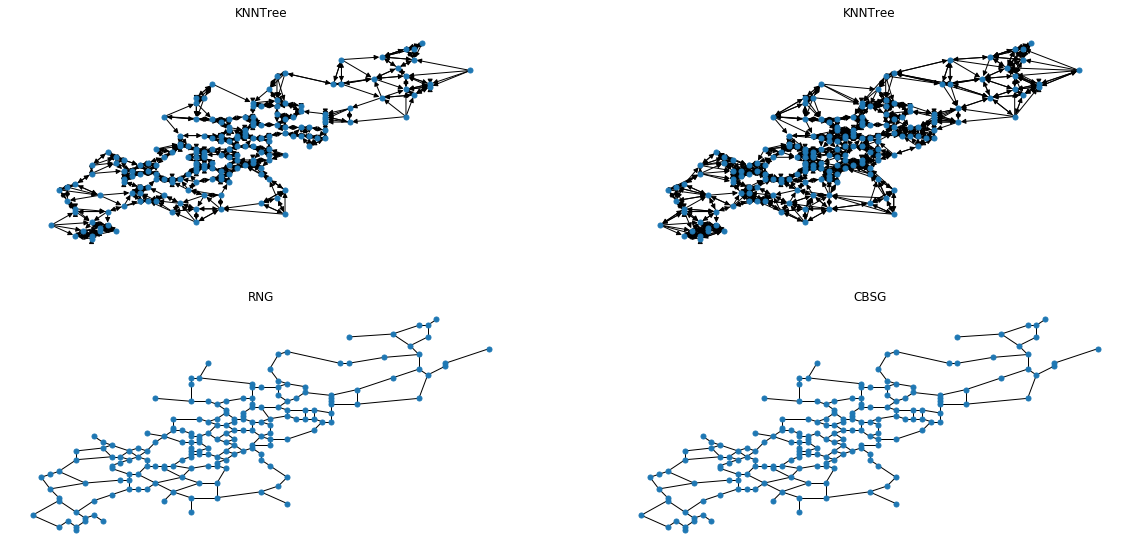

In [8]:
pointIDXY = dict(zip(range(len(df[['x','y']])), np.array(df[['x','y']])))

f = plt.figure(figsize=(20,20))

# # test Delauney
# graph_del = get_delaunay(df)
# plt.subplot(421, figure = f, title = 'Deulaunay')
# nx.draw(graph_del, pointIDXY, node_size=25)



# # test EMST
# graph_mst = get_mst(graph_del)
# plt.subplot(422, figure = f, title = 'EMST')
# nx.draw(graph_mst, pointIDXY, node_size=25)


# test KNNtree
graph = get_knntree(df,4)
plt.subplot(421, figure = f, title = 'KNNTree')
nx.draw(graph, pointIDXY, node_size=25)

# test KNNtree
graph = get_knntree(df,6)
plt.subplot(422, figure = f, title = 'KNNTree')
nx.draw(graph, pointIDXY, node_size=25)

# # test KNCG
# graph_kncg = get_kncg(df, 2)
# plt.subplot(424, figure = f, title = 'KNCG')
# nx.draw(graph_kncg, pointIDXY, node_size=25)


# # test BallTree
# graph = get_balltree(df, 50)
# plt.subplot(425, figure = f, title = 'BallTree')
# nx.draw(graph, pointIDXY, node_size=25)


# # test Convex Hull (CH)
# graph_ch = get_convex_hull(df)
# plt.subplot(426, figure = f, title = 'CH')
# nx.draw(graph_ch, pointIDXY, node_size=25)


# # test GONG
# gong = get_gong(df, 0.3)
# plt.subplot(426, figure = f, title = 'GONG')
# nx.draw(gong, pointIDXY, node_size=25) 


graph_rng = get_rng(df, graph_del, graph_mst)
plt.subplot(423, figure = f, title = 'RNG')
nx.draw(graph_rng, pointIDXY, node_size=25)


# test CBSG
cbsg = get_cbsg(df, 2)
plt.subplot(424, figure = f, title = 'CBSG')
nx.draw(cbsg, pointIDXY, node_size=25) 

plt.show()